In [24]:
import os, gc
import pygrib
import numpy as np
import pandas as pd
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt 


from glob import glob
from functools import partial
from matplotlib import gridspec
from datetime import datetime, timedelta

os.environ['OMP_NUM_THREADS'] = '1'

nbm_dir = '/scratch/general/lustre/u1070830/nbm/'
urma_dir = '/scratch/general/lustre/u1070830/urma/'
tmp_dir = '/scratch/general/lustre/u1070830/tmp/'
os.makedirs(tmp_dir, exist_ok=True)

In [25]:
extract_dir = nbm_dir + 'extract/'
extract_flist = sorted(glob(extract_dir + '*'))
extract_flist

['/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr024.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr030.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr036.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr042.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr048.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr054.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr060.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr066.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr072.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr078.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr084.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr090.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr096.nc',
 '/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr102.nc',
 '/scratch/general/lustre/u1070830

In [26]:
sample0 = xr.open_dataset(extract_flist[0])
sample1 = xr.open_dataset(extract_flist[-1])

start = sample0.valid[0].values
end = sample1.valid[-1].values
interval = '6H'

valid_times = pd.date_range(start, end, freq=interval)

In [27]:
urma_flist = np.hstack(
    [[f for f in glob(urma_dir + '*%s*.WR.grib2'%v.strftime('%Y%m%d%H')) 
      if 'idx' not in f] for v in valid_times])

In [28]:
def open_urma(f, cfengine='pynio'):
    
    try:
        ds = xr.open_dataset(f, engine=cfengine)
        ds['valid'] = datetime.strptime(f.split('/')[-1].split('.')[1], '%Y%m%d%H')
    except:
        return None
    else:
        return ds

if not os.path.isfile('./urma_agg.nc'):

    with mp.get_context('fork').Pool(64) as p:
        urma = p.map(open_urma, urma_flist, chunksize=1)
        p.close()
        p.join()

    urma = [f for f in urma if f is not None]
    urma = xr.concat(urma, dim='valid').rename({'APCP_P8_L1_GLC0_acc':'apcp6h', 
                                                'xgrid_0':'x', 'ygrid_0':'y',
                                                'gridlat_0':'lat', 'gridlon_0':'lon'})
    
else:
    urma = xr.open_dataset('./urma_agg.nc')
    urma.load()

# Double check!
urma = urma['apcp6h']
# urma = urma.isel(x=slice(0, 1131), y=slice(0, 1050)))

In [29]:
fhr = 30
open_file = [f for f in extract_flist if 'fhr%03d'%fhr in f][0]
open_file

'/scratch/general/lustre/u1070830/nbm/extract/nbm_probx_fhr030.nc'

In [30]:
nbm = xr.open_dataset(open_file)
nbm_time = nbm.valid
urma_time = urma.valid

time_match = nbm_time[np.in1d(nbm_time, urma_time)].values

nbm = nbm.sel(valid=time_match)
urma = urma.sel(valid=time_match)

In [31]:
date0 = pd.to_datetime(time_match[0]).strftime('%Y/%m/%d %H UTC')
date1 = pd.to_datetime(time_match[-1]).strftime('%Y/%m/%d %H UTC')

In [32]:
cwa = 'SEW'
nlat, xlat = 46.0, 49.0
nlon, xlon = -125.0, -120.5

lats, lons = nbm.lat, nbm.lon

idx = np.where(
    (lats >= nlat) & (lats <= xlat) &
    (lons >= nlon) & (lons <= xlon))

nbm = nbm.isel(x=slice(idx[1].min(), idx[1].max()), y=slice(idx[0].min(), idx[0].max()))
urma = urma.isel(x=slice(idx[1].min(), idx[1].max()), y=slice(idx[0].min(), idx[0].max()))

In [33]:
def calc_pbin(pbin, _bint, _thresh, _data, _urma):

    p0, p1 = pbin-_bint/2, pbin+_bint/2

    n = xr.where((_data >= p0) & (_data < p1) & (_urma > _thresh), 1, 0)
    N = xr.where((_data >= p0) & (_data < p1), 1, 0)
    #rel = (n.sum(dim=['valid'])/N.sum(dim=['valid']))*100
    rel = (n.sum()/N.sum())*100

    return [pbin, rel, N.sum()]

thresh = 0.50
data = nbm.sel(threshold=thresh)['probx']

total_fc = xr.where(data > 0, 1, 0).sum()
total_ob = xr.where(urma > thresh, 1, 0).sum()

bint = 5
bins = np.arange(0, 101, bint)

calc_pbin_mp = partial(calc_pbin, _bint=bint, _thresh=thresh, _data=data, _urma=urma)

with mp.get_context('fork').Pool(len(bins)) as p:
    returns = p.map(calc_pbin_mp, bins, chunksize=1)
    p.close()
    p.join()
    
returns = np.array(returns)
returns

array([[0.00000000e+00, 4.08950160e+00, 1.44066700e+07],
       [5.00000000e+00, 3.48166849e+01, 9.48258000e+05],
       [1.00000000e+01, 4.31526675e+01, 4.26312000e+05],
       [1.50000000e+01, 4.96389039e+01, 2.66688000e+05],
       [2.00000000e+01, 5.31395490e+01, 1.88801000e+05],
       [2.50000000e+01, 5.57308342e+01, 1.45546000e+05],
       [3.00000000e+01, 5.74956698e+01, 1.18355000e+05],
       [3.50000000e+01, 5.89670875e+01, 9.83820000e+04],
       [4.00000000e+01, 6.05980798e+01, 8.35340000e+04],
       [4.50000000e+01, 6.37162681e+01, 7.29280000e+04],
       [5.00000000e+01, 6.52622608e+01, 6.45350000e+04],
       [5.50000000e+01, 6.33515622e+01, 5.99780000e+04],
       [6.00000000e+01, 6.31190784e+01, 5.57280000e+04],
       [6.50000000e+01, 6.24144303e+01, 5.68250000e+04],
       [7.00000000e+01, 6.45923881e+01, 5.86710000e+04],
       [7.50000000e+01, 6.86053422e+01, 6.39440000e+04],
       [8.00000000e+01, 7.21612262e+01, 7.45040000e+04],
       [8.50000000e+01, 7.55637

In [34]:
fcast_prob = returns[:, 0]/100
obs_freq = returns[:, 1]/100
fcast_count = returns[:, 2]

perf = np.arange(0, 1.1, .1)
o_bar = xr.where(urma > thresh, 1, 0).sum().values/urma.size
climo = o_bar
skill = perf - ((perf - climo)/2)

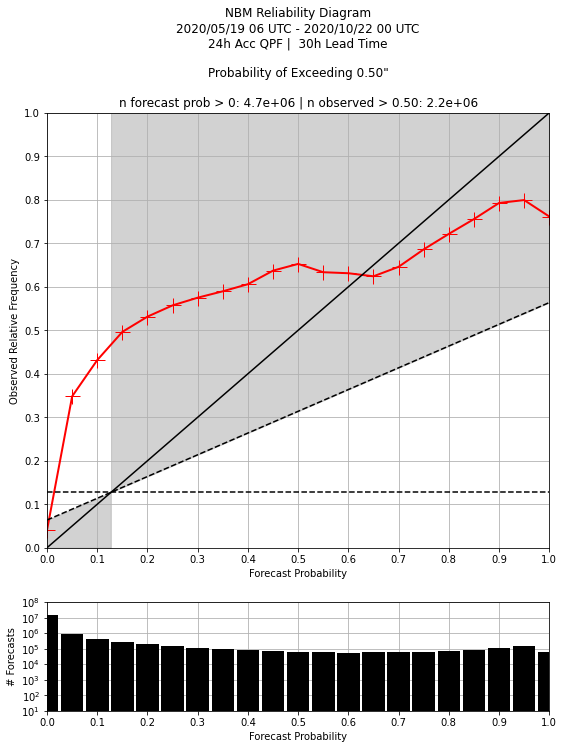

In [35]:
fig = plt.figure(figsize=(9, 11)) 

axs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
ax = plt.subplot(axs[0])
ax1 = plt.subplot(axs[1])

ax.plot(fcast_prob, obs_freq, 
        color='r', linewidth=2,
        marker='+', markersize=15)

ax.plot(perf, perf, 
        color='k')

ax.axhline(climo, 
        color='k', linestyle='--')

ax.plot(perf, skill, 
        color='k', linestyle='--')

focal = climo

fillperf = np.arange(focal, 1, .001)
ax.fill_between(fillperf, fillperf - (fillperf - climo)/2, 1,
        color='gray', alpha=0.35)

fillperf = np.arange(0, focal, .001)
ax.fill_between(fillperf, 0, fillperf - (fillperf - climo)/2,
        color='gray', alpha=0.35)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax.set_xticks(perf)
ax.set_yticks(perf)

ax.set_xlabel('Forecast Probability')
ax.set_ylabel('Observed Relative Frequency')
ax.grid(zorder=1)

ax.set_title((
    'NBM Reliability Diagram\n' +
    '%s - %s\n'%(date0, date1) + 
    '%02dh Acc QPF | %3dh Lead Time\n\n'%(nbm.interval, nbm.fhr) +
    'Probability of Exceeding %.2f"\n\n'%thresh + 
    'n forecast prob > 0: %2.1e | n observed > %.2f: %2.1e'%(total_fc, thresh, total_ob)
))

# # # # # # # # # # # # # # # # # # # # # # # #

ax1.bar(bins, fcast_count, color='k', width=4.5, zorder=10)

ax1.set_xticks(bins[::2])
ax1.set_xticklabels(bins[::2]/100)
ax1.set_xlim([0, 100])

ax1.set_yscale('log')
ax1.set_yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])

ax1.set_xlabel('Forecast Probability')
ax1.set_ylabel('# Forecasts')
ax1.grid(zorder=-1)

plt.show()